In [37]:
%matplotlib notebook

In [38]:
import os
from astropy.io import fits
import pandas as pd
import sys
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import tarfile
from astropy import units as u 
import lsst.daf.persistence as dafPersist

## This Weeks goal
1. Access HiTS light curve data and plot it for at least one variable object
2. Access LSST light curve data for the same object(s) and plot it too

In [39]:
hitsDataDir= '/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename= 'HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath = os.path.join(hitsDataDir, hitsFilename)
hitsTable= fits.open(hitsFilepath) #load data as an astropy fits thing
hitsDf= pd.DataFrame(hitsTable[1].data) #turn data into a pandas dataframe
hitsDf.head()#shows us (prints out) what the dataframe looks like
print(len(hitsDf))
#hitsDf.columns  #all of the things we can access from the data 82 columns


165


In [40]:

#Intermediate goal: get something like "Blind15A_40_s17_LC_5-.tar.gz from a row in the dataframe
testRow = hitsDf.iloc[0]
testRow
tok = testRow['internalID'].split('_')
print(tok)
field = '_'.join([tok[0], tok[1]])
print(field)
ccd = tok[2]
lightcurveTestFile= field + '_' + ccd + '_LC_50.tar.gz'
lightcurveTestPath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
print(lightcurveTestPath)

['Blind15A', '26', 'N1', '1715', '0146']
Blind15A_26
/epyc/users/mrawls/premap2019/hits-dr1/light_curves/Blind15A_26/N1/Blind15A_26_N1_LC_50.tar.gz


In [41]:
def plot_hits(row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS dr1.
    
    Parameters
    ----------
    row: Pandas dataframe row from DR1 source data 
    lcPath: Path on disk to light curves from DR1'''
    tok = row['internalID'].split('_')
    ccd = tok[2]
    field = '_'.join([tok[0], tok[1]])
    lightcurveFile= field + '_' + ccd + '_LC_50.tar.gz'
    #lightcurvePath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t') # load a file with light curve data into the pandas datafram
    fig = plt.figure (figsize = (6, 4))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle= ':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')
    

In [42]:
plot_hits(hitsDf.iloc[22])

<IPython.core.display.Javascript object>

We made it through part 1 of the goals! We have a function we can use to plot any of the 165 HiTS DR1  variable object light curves. We'll pick up from here next time to do part 2 of our goals

In [43]:
repo = '/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1'
butler = dafPersist.Butler(repo)

In [44]:
dbName = 'association.db'
dbPath = os.path.join(repo, dbName)

We are connecting to the database using sqlite3. This wil run two queries to make two pandas dataframes. One is all the objects and one is all the sources. ***objects are composed of one or more sources that have been associated together based on position in the sky.***

These are big dataframes so they will take a little time to load

In [45]:
connection = sqlite3.connect(dbPath)

In [46]:
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection)

Above we have imported/selected all the data from **OBJECTS** that we want from the columns to arange in a table

In [47]:
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

Above we have imported/selected all the data from **SOURCES** that we want from the columns ot arange in a table

In [48]:
objTable.head()
# you could also try objTable.columns


,diaObjectId,ra,decl,nDiaSources,gPSFluxMean,gPSFluxMeanErr,validityEnd,flags,gTOTFluxMean,gTOTFluxMeanErr
0,176486781787570292,151.197871,2.221515,1,NaN,NaN,None,1,-20630.955068,NaN
1,176486781787570326,150.997772,2.329394,1,160.158040,NaN,None,1,196.567166,NaN
2,176486781787570340,151.078542,2.322744,1,10953.513450,NaN,None,1,14866.415796,NaN
3,176486713068093591,149.839390,2.613432,1,2032.066961,NaN,None,1,2230.560014,NaN
4,176486713068093600,149.869474,2.552636,1,NaN,NaN,None,1,1788.147560,NaN


In [49]:
srcTableAll.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags
0,176486781787570292,176486781787570292,151.197871,2.221515,41091531,57070.141866,NaN,NaN,NaN,NaN,-20630.955068,315.430138,25299420
1,176486781787570293,176486781787570293,150.905711,2.283908,41091531,57070.141866,-4.100743e+04,-3.779699e+04,1103.226850,418.586689,48.563316,348.002515,25168348
2,176486781787570294,176486781787570294,150.909445,2.321916,41091531,57070.141866,-4.038756e+06,-3.395545e+06,1968.619372,1530.687159,-194.198280,383.644887,25166840
3,176486781787570295,176486781787570295,150.909175,2.355545,41091531,57070.141866,2.969476e+02,2.072557e+03,1060.795183,413.023842,8852.109173,403.754943,2536
4,176486781787570296,176486781787570296,150.910633,2.361792,41091531,57070.141866,-8.396924e+03,-1.138584e+04,1062.667154,450.717090,32932.733823,440.359122,25168332


Using makeSrcTableFlags to get a version of srcTableAll that has "unpacked" information about the flags we want to use to filter out some obviously bad sources

In [50]:
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags

Now we will write code to disgard the information we deem bad (flags)

In [51]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter']

The unpacked information will return a lot! so we assign variable names to organize the info

In [52]:
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable) #This is making a new table of data without the bad flags!

In [53]:
lsstRas = goodObj.ra
lsstDecs = goodObj.decl
hitsRas = hitsDf.raMedian_feat
hitsDecs = hitsDf.decMedian_feat #Altering the data so for regular function we only get good data

Now we have RA and Decs for both. We want to compare LSST catalogs to Objects in HiTS, but we need something to organize them so that they line up (use Astropy)

In [54]:
hitsCoords = SkyCoord(ra=hitsRas*u.degree, dec=hitsDecs*u.degree) #This allows us to convert the degrees between the different measurment methods
lsstCoords = SkyCoord(ra=lsstRas*u.degree, dec=lsstDecs*u.degree)
idx, d2d, d3d = hitsCoords.match_to_catalog_sky(lsstCoords)#This will compare directly one to another wihtin indices

As before, we have a powerful function that returns lots of stuff, but we only need the indices (saved in idx)

In [55]:
idx  # these are the indices of lsstCoords corresponding to hitsCoords 0, 1, 2, ...

array([23275, 13946, 38703, 11859, 37400,  7466, 22264, 30986, 35177,
       17819, 35180, 38621, 14858, 38394, 19642, 33543,  5618,  7250,
       26124, 12019,  5620, 13801, 11852,  4423, 37147, 38878, 11856,
       28509, 32548, 15050, 31216, 19544, 37528, 17790, 38535, 24220,
       29636,  1112, 35274, 37883, 38935, 38133,  4418, 19840,  7312,
       38058, 38045, 38660,  5780, 37761, 38470, 38504, 37721, 35266,
        1427, 26816, 40799, 14142, 31506, 12372, 12452, 34101,  4851,
       40408, 41545,  1396, 27768, 41709, 39382, 41681,  8892, 19108,
       20399, 10643, 15201, 41226, 43168, 18239, 41370, 25797, 19007,
       17005,  4937, 35334, 44044, 39285,  8362, 15211, 41237,  3927,
        4644, 40330,  3868, 36257, 44435, 39291, 41012, 43615,   717,
       40638, 45124, 44614,  6693, 31487, 41266, 42057, 31288, 44838,
       42051, 44860, 22561, 24612,  5166,   245, 42055, 11226, 36515,
       16150, 17043, 43855, 17165, 33894, 12943, 12757, 12469, 24685,
       15823, 40558,

In [56]:
# for example, this pulls up the row from goodObj that matches hitsDf.iloc[2]
goodObj.iloc[idx[2]]

diaObjectId        176510756295016607
ra                             149.22
decl                          2.59354
nDiaSources                        25
gPSFluxMean                  -140.081
gPSFluxMeanErr                123.453
validityEnd                      None
flags                               1
gTOTFluxMean                   157161
gTOTFluxMeanErr               123.892
Name: 96596, dtype: object

In [57]:
goodObj.iloc[idx[127]]

diaObjectId        176492708842438966
ra                            155.449
decl                         -5.93207
nDiaSources                        18
gPSFluxMean                  -1980.91
gPSFluxMeanErr                109.831
validityEnd                      None
flags                               1
gTOTFluxMean                  94451.2
gTOTFluxMeanErr               108.575
Name: 100290, dtype: object

In [58]:
def plotLsstLightcurve(obj, dbPath, fluxCol='totFlux'):
    '''Plots a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    obj : diaObjectId
        a really long integer that lets us retrieve sources for a single object
    objTable : Pandas dataframe containing DIA Objects
    repo : Butler repository
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    fluxCol : Which flux column to plot?
        choices are totFlux, psFlux, apFlux
    
    '''
    plt.figure(figsize=(6,4))
    connection = sqlite3.connect(dbPath)
    # Load all sources for a single object called "obj"
    srcTable = pd.read_sql_query(f'select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource where diaObjectId = {obj};', connection)
    fluxErrCol = fluxCol + 'Err'
    plt.errorbar(srcTable['midPointTai'], srcTable[fluxCol], yerr=srcTable[fluxErrCol],
                 ls=':', marker='o')
    plt.ylabel(fluxCol + ' (nJy)')
    plt.xlabel('Time (MJD)')

In [59]:
plot_hits(hitsDf.iloc[2])

<IPython.core.display.Javascript object>

Below we will make a light curve with the bad information filtered out. This graph represents data from HiTS, run through LSST software. Our end goal is to compare our light curves to the light curves produced from DEC software and compare the differences!

In [60]:
obj = goodObj.iloc[idx[2]]['diaObjectId']  # can you explain what this line does?
plotLsstLightcurve(obj, dbPath) 

<IPython.core.display.Javascript object>

In [61]:
plot_hits(hitsDf.iloc[127])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


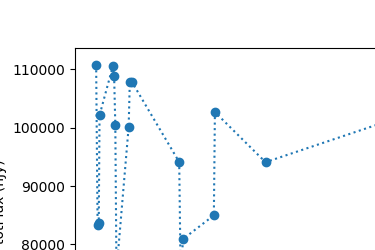

In [62]:
obj = goodObj.iloc[idx[127]]['diaObjectId']  
plotLsstLightcurve(obj, dbPath) 

In [63]:
# Hint: the astropy units module is your friend!
lsstTestMag = (140000*u.nJy).to(u.ABmag)
print(lsstTestMag.value)

18.5346799108044


In [64]:
srcTable = pd.read_sql_query(f'select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource where diaObjectId = {obj};', connection)
x= np.array(goodSrc['totFlux'])
lsstTestMag = (x[127]*u.nJy).to(u.ABmag)
print(lsstTestMag.value)


20.51647438064908


In [77]:
def plotLsstLightcurve(obj, srcTable, row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS dr1.'''
    '''Plots a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    obj : diaObjectId
        a really long integer that lets us retrieve sources for a single object
    objTable : Pandas dataframe containing DIA Objects
    repo : Butler repository
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    fluxCol : Which flux column to plot?
        choices are totFlux, psFlux, apFlux
    
    '''
    plt.figure(figsize=(10,8))
    srcRowFilter= (srcTable['diaObjectId'] == obj)
    srcRow= srcTable.loc[srcRowFilter]
    plt.errorbar(srcRow['midPointTai'], srcRow['magCol'], yerr=srcRow['magErrCol'],
                 ls=':', marker='o')
    
    tok = row['internalID'].split('_')
    ccd = tok[2]
    field = '_'.join([tok[0], tok[1]])
    lightcurveFile= field + '_' + ccd + '_LC_50.tar.gz'
    #lightcurvePath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t') # load a file with light curve data into the pandas dataframe
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle= ':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')

In [71]:
srcTableArray=np.array(srcTableAll['totFlux'])
mag = (srcTableArray*u.nJy).to(u.ABmag)
srcTableAll['magCol'] = mag
srcTableAll.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags,magCol,magErrCol
0,176486781787570292,176486781787570292,151.197871,2.221515,41091531,57070.141866,NaN,NaN,NaN,NaN,-20630.955068,315.430138,25299420,NaN,1.668351e-07
1,176486781787570293,176486781787570293,150.905711,2.283908,41091531,57070.141866,-4.100743e+04,-3.779699e+04,1103.226850,418.586689,48.563316,348.002515,25168348,27.184229,6.424201e-05
2,176486781787570294,176486781787570294,150.909445,2.321916,41091531,57070.141866,-4.038756e+06,-3.395545e+06,1968.619372,1530.687159,-194.198280,383.644887,25166840,NaN,1.457253e-05
3,176486781787570295,176486781787570295,150.909175,2.355545,41091531,57070.141866,2.969476e+02,2.072557e+03,1060.795183,413.023842,8852.109173,403.754943,2536,21.532383,3.037702e-07
4,176486781787570296,176486781787570296,150.910633,2.361792,41091531,57070.141866,-8.396924e+03,-1.138584e+04,1062.667154,450.717090,32932.733823,440.359122,25168332,20.105931,7.486435e-08


In [72]:
magErr = np.abs(-1.0857/srcTableAll['totFluxErr']/srcTableAll['totFlux'])
srcTableAll['magErrCol'] = magErr
srcTableAll.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags,magCol,magErrCol
0,176486781787570292,176486781787570292,151.197871,2.221515,41091531,57070.141866,NaN,NaN,NaN,NaN,-20630.955068,315.430138,25299420,NaN,1.668351e-07
1,176486781787570293,176486781787570293,150.905711,2.283908,41091531,57070.141866,-4.100743e+04,-3.779699e+04,1103.226850,418.586689,48.563316,348.002515,25168348,27.184229,6.424201e-05
2,176486781787570294,176486781787570294,150.909445,2.321916,41091531,57070.141866,-4.038756e+06,-3.395545e+06,1968.619372,1530.687159,-194.198280,383.644887,25166840,NaN,1.457253e-05
3,176486781787570295,176486781787570295,150.909175,2.355545,41091531,57070.141866,2.969476e+02,2.072557e+03,1060.795183,413.023842,8852.109173,403.754943,2536,21.532383,3.037702e-07
4,176486781787570296,176486781787570296,150.910633,2.361792,41091531,57070.141866,-8.396924e+03,-1.138584e+04,1062.667154,450.717090,32932.733823,440.359122,25168332,20.105931,7.486435e-08


<IPython.core.display.Javascript object>


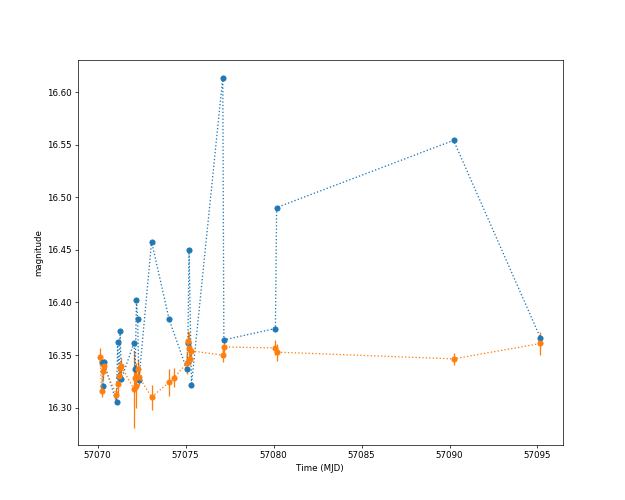

In [84]:

obj = goodObj.iloc[idx[11]]['diaObjectId'] 
row = hitsDf.iloc[11]
plotLsstLightcurve(obj, srcTableAll, row) 

In [ ]:
hola